## Automatic morpheme decomposer using Morpheme Tree
#### Pfeifer Dániel

Data can be found here: https://github.com/sigmorphon/2019/tree/master/task2<br>
I've used all the data contained in folders starting with UD_English.

These files can be found in the DATA folder on GitHub (they're pretty small in size, it shouldn't be an issue to have them there.)

### Word types and conjugations are denoted as:

**N: Noun**
- N;SG = Noun, Singular (can be removed)
- N;PL = Noun, Plural
- PROPN: Proper noun

**V: Verb**
- V: V.MSDR = -ing form
- V.PTCP = Past Participle form
- PASS = Passive form
- PST = Past tense
- IMP = Imperative form (same as regular verb tense)
- IND = Indicative mood (regular verb tense)
- FIN = Auxillary Verb
- SG = Singular
- 3 = 3rd person (-s, -ies)
- NFIN = Not Auxillary Verb (can be removed)
- PRS = Present tense

**ADJ: Adjective**
- ADJ;CMPR = Comparative form (more, worse, better, ...)
- ADJ;RL = Superlative form (best, worst, closest, ...)

**PRO: Pronoun**
- SG = Singular (can be removed)
- ACC = accusative (whom, me, you, him, her, it, us, you, them) (sometimes it's left out though)
- NOM = Nominative forr
- FEM = Feminine (her, NOM: she)
- MASC = Masculine (him, NOM: he)
- NEUT = Neuter (it)
- REFL = reflective (myself, yourself, himself, herself, itself, ourself/ourselves, yourself/yourselves, themself/themselves)

**ADP: Adposition**

**ADV: Adverb** (some words might be Adjectives or Adverbs in some context)

**DET: Determiner**
- SG = Singular (this, that)
- PL = Plural (these, those)
- DEF = Definite article (the)
- INDF = Infedinite article (a, an)
- otherwise: not DEF/INDF (all, any, both, every, some, such, which, ...)

**CONJ: Conjunctions** (and, or)

**INTJ: Interjection** (yes, no, please)

**NUM: Numerical** (one, 1, thousand, null, ...)

**PART: Others Parts of Speech:** (', 's, 2, n't, not, nt, to, n, n't, na, ot, s, ta, the, to, too, ...)

**SG:** % sign

## Part 1: Preparing the Database

The *read_input* function loads in all 5 data files, and swaps all the fancy quotation marks to regular ones.

Then I'm changing the conjugation column such that:
- it's a single list
- the type of the word stem is the first element in the list
- the rest of the particles are in alphabetical order

Other transformations per word type:
- I'm removing the "SG" (Singular) marker from Nouns, since for a lot of nouns only "N" is contained in the conjugation list.
- I'm removing the following from the list of verbs:
    - V.PTCP (this is denoting whether or not the verb is a Particle). Since I'm not doing a sentence-level analysis, this cannot be determined from the word.
    - PL (Plural verb), the data only contained 1, this was most likely a mistake.
    - SG (Singular verb), this only affects "is" -> "be"/"are" and "was"/"were". For now I removed this, later I'll deal with it manually.
    - IMP (Imperative form), this is exactly the same as the regular tense of verbs in English, it cannot be differentiated with non-sentence level analysis.
    - IND (Indicative, regular tense), this didn't appear many of the times, and is unnecessary.
    - FIN (Auxillary verb), I'm adding these to the list of regular verbs (these include words like: will, would, can, could, ... etc.)
    - NFIN (Non-Auxillary verb), this was also left out a lot of the times, I removed them.
    - PRS (Present), again, this didn't appear next to all verbs, and is unnecessary.
- From the list of adjectives and adverbs, I left out "ACC" (accusative case), since it doesn't change the word stem, and "SG" (sigular case) for the same reason.

Finally, I'm transforming everything into a Pandas data base, and lowering every character so words wouldn't differ beacuse of this.

In [58]:
import pandas as pd

def read_input(old_locations,new_location):
    with open(new_location, 'w', encoding='utf8') as new_file:
        for i in range(len(old_locations)):
            with open(old_locations[i],'r', encoding='utf8') as orig_file:
                for line in orig_file:
                    if(line[0] != "#" and line.strip()):
                        new_file.write(
                            line.replace('“','quotation mark').replace('”',
                                        'quotation mark').replace('"','quotation mark'))

def better_inflection_notion(L):
    L.sort()
    for POS in ['PRO','ADJ','ADP','ADV','CONJ','DET','V','N','INTJ','NUM','PART']:
        try:
            i = L.index(POS)
            right_POS = L[i]
            L.pop(i)
            L = [right_POS] + L
        except ValueError:
            continue
    if(L[0] == 'N'):
        try:
            L.remove('SG')
        except ValueError:
            pass
    elif(L[0] == 'V'):
        for p in ['V.PTCP','PASS','PL','IMP','IND','SG','NFIN','PRS']:
            try:
                L.remove(p)
            except ValueError:
                pass
    elif(L[0] == 'ADV' or L[0] == 'ADJ'):
        for p in ['ACC','SG']:
            try:
                L.remove(p)
            except ValueError:
                pass
    elif(L[0] == 'PRO'):
        L = [str(l) for l in L]
    
    return L              

def toPandas(new_location):
    df = pd.read_csv(new_location, sep='\t', encoding='utf8',
                    header=None, names=['word_num','word','word_stem','nan1','nan2','inflection',
                    'nan3','nan4','nan5','nan6'])
    df.word_num = df.word_num.astype(int)
    df = df.replace('quotation mark', '"')
    df = df.drop(['nan1', 'nan2', 'nan3', 'nan4', 'nan5', 'nan6'], axis=1)
    df = df[df.inflection != '_']
    df['inflection'] = df['inflection'].apply(lambda x: x.split(';')).apply(lambda x:
                                                        better_inflection_notion(x))
    df['word'] = df['word'].apply(lambda x: str(x).lower())
    df['word_stem'] = df['word_stem'].apply(lambda x: str(x).lower())
    return df

Then I'm applying the previous functions here. These are the locations for the 5 files I'm using. If you'd like to run my code, please place all the files as I've shown it on GitHub or change this part of the code.

The code creates an "en_combined.txt" file to store the combined data base. I've uploaded that one to GutHub as well.

In [60]:
old_locations = ["../DATA/train/en_ewt-um-train.conllu",
                 "../DATA/train/en_gum-um-train.conllu",
                 "../DATA/train/en_lines-um-train.conllu",
                 "../DATA/train/en_partut-um-train.conllu",
                 "../DATA/train/en_pud-um-train.conllu"]

new_location = "../DATA/formatted_data/en_combined.txt"

read_input(old_locations,new_location)
train = toPandas(new_location)

Taking a look at the data base:

In [61]:
train.head(10)

,word_num,word,word_stem,inflection
0,1,one,one,[NUM]
1,2,huge,huge,[ADJ]
2,3,opportunity,opportunity,[N]
4,1,are,be,"[V, FIN]"
5,2,there,there,[PRO]
6,3,any,any,[DET]
7,4,sadists,sadist,"[N, PL]"
8,5,out,out,[ADV]
9,6,there,there,[ADV]
10,7,who,who,[PRO]


It has 343 thousand rows:

In [62]:
len(train)

343166

## Part 2: Word-conjugating functions

Now I'll write functions that manually transform words into their conjugated form, for example nice -> nicer -> nicest. This isn't a machine learning technique, but it's a start. Now I can ask the computer to provide the comparative or superlative form of any word I provide.

### 2/a) Adjectives

Besides creating functions for the comparative and superlative forms, I'm defining some lists that'll be useful for the following functions. The ones that aren't obvious contain:
- 3-letter words that are of form consonant - vowel - consonant have their last letter doubled in their comparative form, (e.g. red -> redder -> reddest, hot -> hotter -> hottest). The list *doubleConsonants* contains consonant-pairs for which the previous rule still applies, if we replace the first consonant with a double-consonant from the list. (e.g. thin -> thinner -> thinnest, flat -> flatter -> flattest)
- The comparative form of adjectives with 1 or 2 vowels is formed simply by adding an "-er" most of the time, except for the adjectives in the *shortMoreComparativeAdjs* list, for which we add "more ~".

In [63]:
vowels = ['a','e','i','o','u']
consonants = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','w','x','y','z']
consonants_no_y = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','w','x','z']
consonants_no_wy = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','x','z']
consonants_no_xwy = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','z']

irregularAdjComparative = {'bad': 'worse', 'far': 'farther', 'good': 'better', 'ill': 'worse',
                          'less': 'lesser', 'little': 'less', 'many': 'more', 'much': 'more',
                          'well': 'better'}

irregularAdjSuperlative = {'bad': 'worst', 'far': 'farthest', 'good': 'best', 'ill': 'worst',
                          'less': 'least', 'little': 'least', 'many': 'most', 'much': 'most',
                          'well': 'best'}

doubleConsonants = ['bl', 'br', 'ch', 'cl', 'cr', 'dr', 'dw', 'fl', 'fr', 'gh', 'gl', 'gr', 'gw',
                    'kh', 'kl', 'kr', 'pl', 'pr', 'sc', 'sp', 'sr', 'st', 'sw', 'th', 'tr', 'tw']

shortMoreComparativeAdjs = ['clever', 'cruel', 'dead', 'evil', 'modern', 'normal', 'odd', 'perfect',
                            'real','right', 'super', 'upset', 'wrong']

Functions for the comparative and superlative form of adjectives:

(Depending on what the adjective ends with, this might be "r" or "er" / "st, "est" or even "iest".)

In [64]:
def comparative(adj):
    
    if(adj in irregularAdjComparative.keys()):
        return irregularAdjComparative[adj]
    
    elif((len(adj) == 3 and adj[0] in consonants and adj[1] in vowels and adj[2] in consonants_no_y)
                 or (len(adj) == 4 and adj[0:2] in doubleConsonants
                 and adj[2] in vowels and adj[3] in consonants_no_y)):
        return adj + adj[len(adj)-1] + "er"
    
    elif(sum([1 for a in adj if a in vowels]) >= 3 or
            len(adj) >= 3 and (adj[len(adj)-3:len(adj)] == "ful" or adj[len(adj)-3:len(adj)] == "ing")
         or len(adj) >= 3 and adj[len(adj)-2:len(adj)] == "ed"
         or adj in shortMoreComparativeAdjs):
        return "more " + adj
    
    elif(adj[-1] == "y"):
        return adj[0:len(adj)-1] + "ier"
    
    elif(adj[-1] == "e"):
        return adj + "r"
    
    else:
        return adj + "er"

def superlative(adj):
    
    if(adj in irregularAdjSuperlative.keys()):
        return irregularAdjSuperlative[adj]
    
    elif((len(adj) == 3 and adj[0] in consonants and adj[1] in vowels and adj[2] in consonants_no_y)
                 or (len(adj) == 4 and adj[0:2] in doubleConsonants
                 and adj[2] in vowels and adj[3] in consonants_no_y)):
        return adj + adj[len(adj)-1] + "est"
    
    elif(sum([1 for a in adj if a in vowels]) >= 3 or
            len(adj) >= 3 and (adj[len(adj)-3:len(adj)] == "ful" or adj[len(adj)-3:len(adj)] == "ing")
         or len(adj) >= 3 and adj[len(adj)-2:len(adj)] == "ed"
         or adj in shortMoreComparativeAdjs):
        return "most " + adj
    
    elif(adj[-1] == "y"):
        return adj[0:len(adj)-1] + "iest"
    
    elif(adj[-1] == "e"):
        return adj + "st"
    
    else:
        return adj + "est"

Testing for some adjectives:

In [65]:
test_adjectives = ['adorable','awful','homely','quaint','adventurous','fed','horrible','hungry','real',
                   'ill','rich','silly','jealous','dull','great','easy','itchy','important','red']

for a in test_adjectives:
    print(a + " | " + comparative(a) + " | " + superlative(a))

adorable | more adorable | most adorable
awful | more awful | most awful
homely | homelier | homeliest
quaint | more quaint | most quaint
adventurous | more adventurous | most adventurous
fed | fedder | feddest
horrible | more horrible | most horrible
hungry | hungrier | hungriest
real | more real | most real
ill | worse | worst
rich | richer | richest
silly | sillier | silliest
jealous | more jealous | most jealous
dull | duller | dullest
great | greater | greatest
easy | easier | easiest
itchy | itchier | itchiest
important | more important | most important
red | redder | reddest


In [66]:
comparative('envy')

'envier'

Unfortunately this cannot be obtained from the data I've used, because of some reason the word stem of adjectives in comparative or superlative form is still the same as the word itself:

In [67]:
train[train['inflection'].apply(lambda x: x == ['ADJ','CMPR'])].head(10)

,word_num,word,word_stem,inflection
1321,5,more,more,"[ADJ, CMPR]"
1360,1,worse,worse,"[ADJ, CMPR]"
1363,4,worse,worse,"[ADJ, CMPR]"
1457,14,better,better,"[ADJ, CMPR]"
1602,12,more,more,"[ADJ, CMPR]"
1762,18,higher,higher,"[ADJ, CMPR]"
1770,26,earlier,earlier,"[ADJ, CMPR]"
1890,4,safer,safer,"[ADJ, CMPR]"
2180,7,wider,wider,"[ADJ, CMPR]"
2521,12,larger,larger,"[ADJ, CMPR]"


In [68]:
train[train['inflection'].apply(lambda x: x == ['ADJ','RL'])].head(10)

,word_num,word,word_stem,inflection
129,8,best,best,"[ADJ, RL]"
982,1,best,best,"[ADJ, RL]"
1032,46,best,best,"[ADJ, RL]"
1272,13,worst,worst,"[ADJ, RL]"
1738,18,best,best,"[ADJ, RL]"
1871,16,closest,closest,"[ADJ, RL]"
2026,20,best,best,"[ADJ, RL]"
2421,8,best,best,"[ADJ, RL]"
3148,1,cleanest,cleanest,"[ADJ, RL]"
3240,7,most,most,"[ADJ, RL]"


### 2/b Adverbs

Conjugation of adverbs are the same as adjectives, except if it ends with "-ly", then it surely gains "more" for the comparative, and "most" for the superlative form.<br>Moreover, there is 1 exceptions: "badly" -> "worse" -> "worst".

In [69]:
def comparative_adv(adv):
    
    if(adv == "badly"):
        return "worse"
    
    elif(adv[len(adv)-2:len(adv)] == "ly"):
        return "more " + adv

    else:
        return comparative(adv)

def superlative_adv(adv):
    
    if(adv == "badly"):
        return "worst"
    
    elif(adv[len(adv)-2:len(adv)] == "ly"):
        return "most " + adv

    else:
        return superlative(adv)

Testing the adverb-conjugator:

In [70]:
test_adverbs = ['badly','adorable','awfully','homely','quaint','adventurously','fed','horribly',
                'hungrily','real','ill','rich','silly','jealously','dull','greatly','easily',
                'itchy','importantly','red']

for a in test_adverbs:
    print(a + " | " + comparative_adv(a) + " | " + superlative_adv(a))

badly | worse | worst
adorable | more adorable | most adorable
awfully | more awfully | most awfully
homely | more homely | most homely
quaint | more quaint | most quaint
adventurously | more adventurously | most adventurously
fed | fedder | feddest
horribly | more horribly | most horribly
hungrily | more hungrily | most hungrily
real | more real | most real
ill | worse | worst
rich | richer | richest
silly | more silly | most silly
jealously | more jealously | most jealously
dull | duller | dullest
greatly | more greatly | most greatly
easily | more easily | most easily
itchy | itchier | itchiest
importantly | more importantly | most importantly
red | redder | reddest


### 2/c Nouns

There is only one type of conjugation for nouns: Plural form. However there are exceptions (*irregularNounPlurals*), and if the last letter(s) of the word are:
- ix, ex, then "ex" is removed and the word gain "-ices" (e.g. matrix -> matrices, vertex -> vertices)
- s, x, z, ch or sh, then the word gains "-es"-t , not just "-s" (e.g. business -> businesses, match -> matches)
- y, then y is removed and the word gains "-ies"-t (except if it's 3 characters long and the 2nd. letter is a vowel or if it's 4 characters long and the 3rd letter is a vowel, e.g. boys, days, rays, trays, ...)

In [71]:
irregularNounPlurals = {'woman': 'women', 'man': 'men', 'child': 'children', 'tooth': 'teeth',
                        'foot': 'feet', 'person': 'people', 'leaf': 'leaves', 'mouse': 'mice',
                        'goose': 'geese', 'half': 'halves', 'knife': 'knives', 'wife': 'wives',
                        'life': 'lives', 'elf': 'elves', 'loaf': 'loaves', 'potato': 'potatoes',
                        'tomato': 'tomatoes', 'cactus': 'cacti', 'focus': 'foci', 'fungus': 'fungi',
                        'nucleus': 'nuclei', 'syllabus': 'syllabi', 'analysis': 'analyses',
                        'diagnosis': 'diagnoses', 'oasis': 'oases', 'thesis': 'theses',
                        'crisis': 'crises', 'phenomenon': 'phenomena', 'criterion': 'criteria',
                        'datum': 'data'}

In [72]:
def noun_plural(noun):
    special_endings = ['s', 'x', 'z', 'ch', 'sh']
    
    if(noun in irregularNounPlurals.keys()):
        return irregularNounPlurals[noun]
    elif(len(noun) >= 5 and noun[len(noun)-2:len(noun)] in ['ix','ex']):
        return noun[0:len(noun)-2] + "ices"
    elif(noun[len(noun)-1:len(noun)] in ['s', 'x', 'z']
       or noun[len(noun)-2:len(noun)] in ['ch', 'sh']):
        return noun + "es"
    elif(noun[len(noun)-1:len(noun)] == 'y' and
        not (len(noun) == 3 and noun[1] in vowels or
             len(noun) == 4 and noun[2] in vowels)):
        return noun[0:len(noun)-1] + "ies"
    else:
        return noun + "s"

Testing noun plurals:

In [73]:
noun_test = ['area','book','business','case','child','company','country','day','eye','fact','family',
             'government','group','hand','home','job','life','lot','man','money','month','mother',
             'night','number','part','person','place','point','problem','program','question','right',
             'room','school','state','story','student','study','system','thing','time','water','way',
             'week','woman','word','work','world','year']
for n in noun_test:
    print(n + " | " + noun_plural(n))

area | areas
book | books
business | businesses
case | cases
child | children
company | companies
country | countries
day | days
eye | eyes
fact | facts
family | families
government | governments
group | groups
hand | hands
home | homes
job | jobs
life | lives
lot | lots
man | men
money | moneies
month | months
mother | mothers
night | nights
number | numbers
part | parts
person | people
place | places
point | points
problem | problems
program | programs
question | questions
right | rights
room | rooms
school | schools
state | states
story | stories
student | students
study | studies
system | systems
thing | things
time | times
water | waters
way | ways
week | weeks
woman | women
word | words
work | works
world | worlds
year | years


### 2/d Verbs
First I'll construct the -ing form of a verb. In most cases, this is formed by simply adding "ing", except if:
- the verb ends with "-ie", then "ie" is removed, and +"ying" is added
- the verb end with consonant+"e", then "e" is removed, and +"ing" is added
- the verb consists of 1 short syllable, then the last 2 letters are doubled (e.g. betting, ripping, ...)
- the verbs contains the following prefixes, and the previous applies without the prefix (e.g. beginning, overfitting, ...)

In [74]:
prefix2 = ['be','de','on','il','im','in','ir','re','un','up']
prefix3 = ['con','dis','for','mid''mis','non','off','out','pre','pro','sub']
prefix4 = ['anti','auto','down','mega','over','post','semi','tele']
prefix5 = ['extra','hyper','inter','super','trans','ultra','under']

In [75]:
def verb_ing(verb):
    if(len(verb) >= 3 and verb[len(verb)-2:len(verb)] == 'ie'):
        return verb[0:len(verb)-2] + "ying"
    elif(((len(verb) >= 3 and sum([1 for a in verb if a in vowels]) == 1) or
         (len(verb) >= 5 and verb[0:2] in prefix2
          and sum([1 for a in verb[2:] if a in vowels]) == 1) or
         (len(verb) >= 6 and verb[0:3] in prefix3
          and sum([1 for a in verb[3:] if a in vowels]) == 1) or
         (len(verb) >= 7 and verb[0:4] in prefix4
          and sum([1 for a in verb[4:] if a in vowels]) == 1) or
         (len(verb) >= 8 and verb[0:5] in prefix5
          and sum([1 for a in verb[5:] if a in vowels]) == 1)) and
         verb[-3] not in vowels and
         verb[-2] in vowels and verb[-1] in consonants_no_xwy):
        return verb + verb[-1] + "ing"
    elif(len(verb) >= 3 and verb[-2] in consonants and verb[-1] == 'e'):
        return verb[0:len(verb)-1] + "ing"
    else:
        return verb + "ing"

Testing:

In [76]:
verb_test = ['ask','be','become','begin','call','come','concur','do','feel','find','get',
             'give','go','have','hear','help','keep','know','leave','let','like','live',
             'look','make','mean','move','need','play','put','run','say','see','seem',
             'show','start','take','talk','tell','think','try','turn','use','want','work']
for v in verb_test:
    print(v + " | " + verb_ing(v))

ask | asking
be | being
become | becoming
begin | beginning
call | calling
come | coming
concur | concurring
do | doing
feel | feeling
find | finding
get | getting
give | giving
go | going
have | having
hear | hearing
help | helping
keep | keeping
know | knowing
leave | leaving
let | letting
like | liking
live | living
look | looking
make | making
mean | meaning
move | moving
need | needing
play | playing
put | putting
run | running
say | saying
see | seeing
seem | seeming
show | showing
start | starting
take | taking
talk | talking
tell | telling
think | thinking
try | trying
turn | turning
use | using
want | wanting
work | working


The present singular 3rd person form of a verb is formed by adding an "s", except that:
- if the verb ends with consonant+"y", then the "y" is removed and +"ies" is added
- if the verb ends with s, sh, or tch, then "es" is added (not just "s")
- there are some verbs conjugated differently (*specialVerb_s*)

In [77]:
specialVerb_s = {'be': 'is', 'have': 'has', 'do': 'does', 'go': 'goes'}

In [78]:
def verb_s(verb):
    if(verb in specialVerb_s.keys()):
        return specialVerb_s[verb]
    elif(len(verb) >= 2 and verb[-2] in consonants_no_y and verb[-1] == 'y'):
        return verb[0:len(verb)-1] + "ies"
    elif(len(verb) >= 2 and verb[-1] == 's' or
        len(verb) >= 3 and verb[-2:] == 'sh' or
        len(verb) >= 4 and verb[-3:] == 'tch'):
        return verb + "es"
    else:
        return verb + "s"

I added a verb from each category above (ending with s, sh or tch), and it's working:

In [79]:
verb_test += ['pass','wash','catch']
for v in verb_test:
    print(v + " | " + verb_s(v))

ask | asks
be | is
become | becomes
begin | begins
call | calls
come | comes
concur | concurs
do | does
feel | feels
find | finds
get | gets
give | gives
go | goes
have | has
hear | hears
help | helps
keep | keeps
know | knows
leave | leaves
let | lets
like | likes
live | lives
look | looks
make | makes
mean | means
move | moves
need | needs
play | plays
put | puts
run | runs
say | says
see | sees
seem | seems
show | shows
start | starts
take | takes
talk | talks
tell | tells
think | thinks
try | tries
turn | turns
use | uses
want | wants
work | works
pass | passes
wash | washes
catch | catches


I'm finally using the data! I can't create rules for the past tense of a verb, so I'm gaining this information from the data. This code collects this data into a dictionary:

In [80]:
verb_pasts = {}
for i, row in train[train['inflection'].apply(lambda x:
            x == ['V','FIN','PST'])][['word','word_stem']].iterrows():
    if(row['word_stem'] not in verb_pasts):
        verb_pasts[row['word_stem']] = row['word']
len(verb_pasts)

1029

Same for the Past Participle form:

In [81]:
verb_2nd_pasts = {}
for i, row in train[train['inflection'].apply(lambda x:
            x == ['V','PST'])][['word','word_stem']].iterrows():
    if(row['word_stem'] not in verb_2nd_pasts):
        verb_2nd_pasts[row['word_stem']] = row['word']
len(verb_2nd_pasts)

1504

However, if the verb is not contained in our data, then I wrote a function called *verb_simple_past* built upon the "-ing" conjugator, but instead of "-ing" or "-ng" it adds "-ed" or "-d" to the verb. This is obviously not always correct, but I can't get better from the data I've used.

In [82]:
def verb_simple_past(verb):

    if(((len(verb) >= 3 and sum([1 for a in verb if a in vowels]) == 1) or
         (len(verb) >= 5 and verb[0:2] in prefix2
          and sum([1 for a in verb[2:] if a in vowels]) == 1) or
         (len(verb) >= 6 and verb[0:3] in prefix3
          and sum([1 for a in verb[3:] if a in vowels]) == 1) or
         (len(verb) >= 7 and verb[0:4] in prefix4
          and sum([1 for a in verb[4:] if a in vowels]) == 1) or
         (len(verb) >= 8 and verb[0:5] in prefix5
          and sum([1 for a in verb[5:] if a in vowels]) == 1)) and
         verb[-3] not in vowels and
         verb[-2] in vowels and verb[-1] in consonants_no_xwy):
        return verb + verb[-1] + "ed"
    elif(len(verb) >= 3 and verb[-2] in consonants and verb[-1] == 'e'):
        return verb + "d"
    else:
        return verb + "ed"

And finally, these two functions use the previos dictionaries and the previous function to put a verb into past tense. If the verb is contained in our dictionaries, then they look up the word in those, otherwise, they use the previous function:

In [83]:
def verb_past(verb,case='SG'):
    if(verb == "be"):
        if(case == "SG"):
            return "was"
        elif(case == "PL"):
            return "were"
    elif(verb in verb_pasts.keys()):
        return verb_pasts[verb]
    else:
        return verb_simple_past(verb)

def verb_2nd_past(verb):
    if(verb in verb_2nd_pasts.keys()):
        return verb_2nd_pasts[verb]
    else:
        return verb_simple_past(verb)

Testing:

In [84]:
for v in verb_test:
    print(v + " | " + verb_past(v) + " | " + verb_2nd_past(v))

ask | asked | asked
be | was | been
become | became | become
begin | began | begun
call | called | called
come | came | come
concur | concurred | concurred
do | did | done
feel | felt | felt
find | found | found
get | got | gotten
give | gave | given
go | went | gone
have | had | had
hear | heard | heard
help | helped | helped
keep | kept | kept
know | knew | known
leave | left | left
let | let | let
like | liked | liked
live | lived | lived
look | looked | looked
make | made | made
mean | meant | meant
move | moved | moved
need | needed | needed
play | played | played
put | put | put
run | ran | run
say | said | said
see | saw | seen
seem | seemed | seemed
show | showed | showed
start | started | started
take | took | taken
talk | talked | talked
tell | told | told
think | thought | thought
try | tried | tried
turn | turned | turned
use | used | used
want | wanted | wanted
work | worked | worked
pass | passed | passed
wash | washed | washed
catch | caught | caught


### Part 3: Lists for conjugated forms

Now I'm creating some lists that use our input data to find out the conjugated form of each word.

### 3/a: Nouns and Plural Nouns

I'm getting each noun from our data base (if it was in a conjugated form, them only the word stem). This way, I get the largest possible set of nouns from the data.

In [85]:
Noun_list = list(set(train[train['inflection'].apply(lambda x: 'N' in x)]['word_stem']))
Noun_PL_list = [noun_plural(n) for n in Noun_list]
print(Noun_list[0:20])
print()
print(Noun_PL_list[0:20])

['poo', 'go', 'invention', 'purchase', 'carpet', 'fm', 'postage', 'changing', 'tribunal', 'proclaimer', 'squeak', 'lake', 'drought', 'podium', 'channel', 'abstention', 'scandal', 'petroleum', 'tzu', 'presidency']

['poos', 'gos', 'inventions', 'purchases', 'carpets', 'fms', 'postages', 'changings', 'tribunals', 'proclaimers', 'squeaks', 'lakes', 'droughts', 'podiums', 'channels', 'abstentions', 'scandals', 'petroleums', 'tzus', 'presidencies']


### 3/b Verbs

I'm doing the same, and looking at all the possible Verb conjugations.

In [86]:
Verb_list = list(set(train[train['inflection'].apply(lambda x: 'V' in x)]['word_stem']))
Verb_ing_list = [verb_ing(v) for v in Verb_list]
Verb_s_list = [verb_s(v) for v in Verb_list]
Verb_past_list_SG = [verb_past(v,case='SG') for v in Verb_list]
Verb_past_list_PL = [verb_past(v,case='PL') for v in Verb_list]
Verb_2nd_past_list = [verb_2nd_past(v) for v in Verb_list]

print(Verb_list[0:20])
print()
print(Verb_ing_list[0:20])
print()
print(Verb_s_list[0:20])
print()
print(Verb_past_list_SG[0:20])
print()
print(Verb_past_list_PL[0:20])
print()
print(Verb_2nd_past_list[0:20])

['reemploy', 'go', 'accecpt', 'skill', 'jam', 'purchase', 'impress', 'damage', 'die', 'retake', 'disrupt', 'penalise', 'fete', 'burgeon', 'score', 'tumble', 'channel', 'ordain', 'swirl', 'clap']

['reemploying', 'going', 'accecpting', 'skilling', 'jamming', 'purchasing', 'impressing', 'damaging', 'dying', 'retaking', 'disrupting', 'penalising', 'feting', 'burgeoning', 'scoring', 'tumbling', 'channeling', 'ordaining', 'swirling', 'clapping']

['reemploys', 'goes', 'accecpts', 'skills', 'jams', 'purchases', 'impresses', 'damages', 'dies', 'retakes', 'disrupts', 'penalises', 'fetes', 'burgeons', 'scores', 'tumbles', 'channels', 'ordains', 'swirls', 'claps']

['reemployed', 'went', 'accecpted', 'skilled', 'jammed', 'purchased', 'impressed', 'damaged', 'died', 'retook', 'disrupted', 'penalised', 'feted', 'burgeoned', 'scored', 'tumbled', 'channeled', 'ordained', 'swirled', 'clapped']

['reemployed', 'went', 'accecpted', 'skilled', 'jammed', 'purchased', 'impressed', 'damaged', 'died', 'reto

### 3/c Adjectives

In [87]:
Adj_list = list(set(train[train['inflection'].apply(lambda x: x == ['ADJ'])]['word_stem']))
Adj_cmpr_list = [comparative(a) for a in Adj_list]
Adj_rl_list = [superlative(a) for a in Adj_list]

print(Adj_list[0:20])
print()
print(Adj_cmpr_list[0:20])
print()
print(Adj_rl_list[0:20])

['enhanced', 'upstairs', 'cultural', 'south-eastern', 'crucial', 'eighth', 'phoney', 'healthy', 'fraught', 'browned', 'pro-active', 'strawberry', 'cardinal', 'disorderly', 'delinquent', 'outstanding', 'burgeon', 'rough-skinned', 'generational', 'totalitarian']

['more enhanced', 'more upstairs', 'more cultural', 'more south-eastern', 'more crucial', 'eighther', 'phoneier', 'healthier', 'fraughter', 'more browned', 'more pro-active', 'strawberrier', 'more cardinal', 'more disorderly', 'more delinquent', 'more outstanding', 'more burgeon', 'more rough-skinned', 'more generational', 'more totalitarian']

['most enhanced', 'most upstairs', 'most cultural', 'most south-eastern', 'most crucial', 'eighthest', 'phoneiest', 'healthiest', 'fraughtest', 'most browned', 'most pro-active', 'strawberriest', 'most cardinal', 'most disorderly', 'most delinquent', 'most outstanding', 'most burgeon', 'most rough-skinned', 'most generational', 'most totalitarian']


### 3/d Adverbs

Note: Not all Adverbs created this way have a meaning, however, this won't be an issue at detection. All inputted words at the end will be able to be detected as Adverbs as well.

In [88]:
Adv_list = list(set(train[train['inflection'].apply(lambda x: 'ADV' in x)]['word_stem']))
Adv_cmpr_list = [comparative_adv(a) for a in Adv_list]
Adv_rl_list = [superlative_adv(a) for a in Adv_list]

print(Adv_list[0:20])
print()
print(Adv_cmpr_list[0:20])
print()
print(Adv_rl_list[0:20])

['veryyyy', 'upstairs', 'luckily', 'majestical', 'finally', 'proud', 'flat', 'deffly', 'asap', 'originally', 'along', 'squarely', 'sporadically', 'hard', 'mechanicly', 'languidly', 'virtually', 'young', 'madly', 'specifically']

['veryyyier', 'more upstairs', 'more luckily', 'more majestical', 'more finally', 'prouder', 'flatter', 'more deffly', 'asaper', 'more originally', 'alonger', 'more squarely', 'more sporadically', 'harder', 'more mechanicly', 'more languidly', 'more virtually', 'younger', 'more madly', 'more specifically']

['veryyyiest', 'most upstairs', 'most luckily', 'most majestical', 'most finally', 'proudest', 'flattest', 'most deffly', 'asapest', 'most originally', 'alongest', 'most squarely', 'most sporadically', 'hardest', 'most mechanicly', 'most languidly', 'most virtually', 'youngest', 'most madly', 'most specifically']


### 3/e Pronouns

In [89]:
Pro_gen = list(set(train[train['inflection'].apply(lambda x: x == ['PRO'])]['word']))
print(Pro_gen)

['ya', 'that', 'thou', 'his', 'they', 'thei', "'ya", 'thier', 'thy', 'the', 'all', 'yuor', 'any', 'yer', 'ur', 'whoooooo', 'most', 'what', 'every', 'whoever', 'their', 'whatnot', 'which', 'another', 'either', 'ours', 'half', 'several', 'waht', "'em", 'wht', 'such', 'em', 'ye', 'is', 'some', 'quite', "who's", "you're", 'there', 's', 'ever', 'you', 'hers', 'nobody', 'oneself', 'whatever', 'theyy', 'third', 'whose', 'when', 'yo', 'wtf', 'theirs', 'mines', 'mine', 's/he', 'where', 'self', 'one', "'ye", 'ti', 'none', '’s', 'second', 'whomever', 'each', 'first', "ya'll", 'u', "it's", 'our', 'use', 'yours', 'it', 'nothing', 'whom', "wha'", 'who', 'latter', 'whereby', 'both']


### 3/f Determiners

There are 5 types of this in our data, however, the last 4 only contain some special words, and most are in the first, "general" category.

In [90]:
Det_gen_list = list(set(train[train['inflection'].apply(lambda x: x == ['DET'])]['word']))
print(Det_gen_list)

['many', 'then', 'sm', 'more', 'that', 'another', 'no', 'his', 'teh', 'nary', 'either', 'certain', 'whatever', 'half', 'the', 'each', 'and', 'several', 'all', 'any', 'dthat', 'such', 'he', 'other', 'our', 'neither', 'what', 'le', 'every', 'your', 'te', 'their', 'l', 'some', 'which', 'aa', 'both', 'whhich', 'quite', 'her', 'there', '6']


In [91]:
Det_sg_list = list(set(train[train['inflection'].apply(lambda x: x == ['DET','SG'])]['word']))
print(Det_sg_list)

['this', 'one', 'the', 'each', 'that', 'every', 'its', 'une', 'my']


In [92]:
Det_pl_list = list(set(train[train['inflection'].apply(lambda x: x == ['DET','PL'])]['word']))
print(Det_pl_list)

['many', 'these', 'those']


In [93]:
Det_def_list = list(set(train[train['inflection'].apply(lambda x: x == ['DET','DEF'])]['word']))
print(Det_def_list)

['’s', 'the']


In [94]:
Det_indf_list = list(set(train[train['inflection'].apply(lambda x: x == ['DET','INDF'])]['word']))
print(Det_indf_list)

['an', 'a']


### 3/g Proper Nouns

Their plural form is the same as for regular Nouns, however, they sometimes don't have a meaning. But this won't bother as at detection.

In [95]:
Propn_list = list(set(train[train['inflection'].apply(lambda x: 'PROPN' in x)]['word_stem']))
Propn_pl_list = [noun_plural(n) for n in Propn_list]
print(Propn_list[0:50])
print()
print(Propn_pl_list[0:50])

['quantcast', 'yang', 'cowpland', 'purchase', 'fm', 'suleiman', 'die', 'gamestops', 'lake', 'seychelles', 'channel', 'barros', 'bible', 'presidency', 'leon', 'window', 'sixth', 'vladi', 'robin', 'barón', 'iraqi', 'cousin', 'burgoyne', 'samnium', 'wolak', 'indiana', 'chinese', 'hunter', 'yiu', 'landfall', 'i-244', 'controller', 'workshop', 'simons', 'dulaymi', 'nadu', 'clint', 'basse', 'ed', 'dominica', 'sejanus', 'erin', 'bilbray', 'amrullah', 'analytic', 'goshawk', 'inford', 'dartmouth', 'arp', 'shindand']

['quantcasts', 'yangs', 'cowplands', 'purchases', 'fms', 'suleimans', 'dies', 'gamestopses', 'lakes', 'seychelleses', 'channels', 'barroses', 'bibles', 'presidencies', 'leons', 'windows', 'sixths', 'vladis', 'robins', 'baróns', 'iraqis', 'cousins', 'burgoynes', 'samniums', 'wolaks', 'indianas', 'chineses', 'hunters', 'yius', 'landfalls', 'i-244s', 'controllers', 'workshops', 'simonses', 'dulaymis', 'nadus', 'clints', 'basses', 'eds', 'dominicas', 'sejanuses', 'erins', 'bilbraies', 

The following function returns a pronoun given a the pronoun typecode (I'll use this and many others at word-generation):

In [96]:
def pro(name):
    '''
    PROPOSITIONS
    ------------
    num: SG (singular) or PL (plural)
    person: 1, 2 or 3
    mode: NOM (nominative), ACC (accusative), POSS (possessive) or REFL (reflective)
    gender: MASC (masculine), FEM (feminine) or NEUT (neutral) [optional for the SG/3 case]
    '''
    
    name_list = name.split(';')
    if(len(name_list) == 4):
        prop, case, person, mode = tuple(name_list)
    elif(len(name_list) == 5):
        prop, case, person, gender, mode = tuple(name_list)
    else:
        raise NameError('Error in proposition function attributes:\n' + 
            'name must have length 4 or 5,\n' + 
            'but given name length is ' + str(len(name_list)))
    
    if(case == 'SG'):
        if(person == '1'):
            if(mode == 'NOM'):
                return "I"
            elif(mode == 'ACC'):
                return "me"
            elif(mode == 'POSS'):
                return 'mine'
            elif(mode == 'REFL'):
                return 'myself'
        elif(person == '2'):
            if(mode == 'NOM'):
                return "you"
            elif(mode == 'ACC'):
                return "you"
            elif(mode == 'POSS'):
                return 'yours'
            elif(mode == 'REFL'):
                return 'yourself'
        elif(person == '3' and gender == 'NEUT'):
            if(mode == 'NOM'):
                return "it"
            elif(mode == 'ACC'):
                return "it"
            elif(mode == 'POSS'):
                return 'its'
            elif(mode == 'REFL'):
                return 'itself'
        elif(person == '3' and gender == 'MASC'):
            if(mode == 'NOM'):
                return "he"
            elif(mode == 'ACC'):
                return "him"
            elif(mode == 'POSS'):
                return 'his'
            elif(mode == 'REFL'):
                return 'himself'
        elif(person == '3' and gender == 'FEM'):
            if(mode == 'NOM'):
                return "she"
            elif(mode == 'ACC'):
                return "her"
            elif(mode == 'POSS'):
                return 'her'
            elif(mode == 'REFL'):
                return 'herself'
    elif(case == 'PL'):
        if(person == '1'):
            if(mode == 'NOM'):
                return "we"
            elif(mode == 'ACC'):
                return "us"
            elif(mode == 'POSS'):
                return 'our'
            elif(mode == 'REFL'):
                return 'ourselves'
        if(person == '2'):
            if(mode == 'NOM'):
                return "you"
            elif(mode == 'ACC'):
                return "you"
            elif(mode == 'POSS'):
                return 'yours'
            elif(mode == 'REFL'):
                return 'yourselves'
        if(person == '3'):
            if(mode == 'NOM'):
                return "they"
            elif(mode == 'ACC'):
                return "them"
            elif(mode == 'POSS'):
                return 'their'
            elif(mode == 'REFL'):
                return 'themselves'
    else:
        raise NameError('Error in proposition function attributes:\n' + 
            'Case must be either "SG" or "PL"; Person must be either 1, 2 or 3;\n' + 
            'Mode must be either "NOM", "ACC", "POSS" or "REFL"; gender must be\neither None, ' +
            '"NEUT", "MASC" or "FEM".')
        

Examples: 

In [97]:
pro("PRO;SG;2;REFL")

'yourself'

In [98]:
pro("PRO;SG;3;FEM;ACC")

'her'

In [99]:
pro("PRO;PL;1;POSS")

'our'

### 3/h Adpositions

In [100]:
Adp_list = list(set(train[train['inflection'].apply(lambda x: 'ADP' in x)]['word']))
print(Adp_list[0:50])

['underneath', 'that', 'for', 'along', 'btwn', 'above', 'the', 'prior', 'sure', 'because', 'amoung', 'astride', 'b/t', 'behind', 'throughout', 'atop', 'as', 'between', 'via', 'f', 'do', 'down', 'among', 'w/', 'aboout', 'regardless', 'under', 'whereas', 'about', 'besides', 'onto', 'at', 'til', '-', 'without', 'dans', 'due', 'together', 'in', 'since', 'a.k.a', 'though', 'd', 'while', 'ala', 'so', 'w', 'w/o', 'int', 'after']


### 3/i Conjunction

In [101]:
Conj_list = list(set(train[train['inflection'].apply(lambda x: 'CONJ' in x)]['word']))
print(Conj_list[0:50])

['that', 'for', 'th', 'namely', '&amp;', 'an', 'prior', 'why', 'et', 'because', 'n', 'as', 'between', '&', 'neither', 'whereas', 'about', 'bc', 'besides', 'at', 'whether', 'whenever', '-', 'without', 'wherever', 'whie', 'in', 'since', 'though', 'either', 'while', '/', 'so', 'after', 'adn', 'how', 'even', 'beacuse', 'till', 'becouse', 'such', 'instead', 'becuse', 'unlike', 'from', 'vs.', 'afnd', 'or', 'vs', 'although']


### 3/j Interjections

In [102]:
Intj_list = list(set(train[train['inflection'].apply(lambda x: 'INTJ' in x)]['word']))
print(Intj_list[0:50])

['ya', 'umm', 'farewell', 'mmh', 'ough', 'hehe', 'good-by', 'yea', 'greetings', 'anyways', 'my', 'ummmm', 'ye$', 'huh', 'yeaa', 'high', 'gosh', 'sry', 'bravo', 'sure', 'nope', 'good', 'uhh', 'etc.', 'hmm', 'hurrah', 'wow', 'behold', 'heavens', 'yuk', 'ty', 'ugh', 'wel', 'right', 'yes', 'aaaaaggghhhhhh', 'heh', 'btw', 'well', 'whasssup', 'shucks', 'υes', 'hahahaahh', 'so-o-o', 'uh', 'aye', 'sorry', 'oops', 'omg', 'fine']


### 3/k Numerical words

In [103]:
Num_list = list(set(train[train['inflection'].apply(lambda x: 'NUM' in x)]['word']))
print(Num_list[0:50])

['460,000', '750,000', '4.0', '1904', '53', '713-546-5000', '1179', "'67", '243,000', '62,500', '3/10/00', '2710', '1934', '869', '713-853-3044', '4350', '36', '06/01/2001', 'nineteen', 'six-forty-one', '27,886', 'vii', '362416', '396', '1950', '700', '11831', 'no-6', '1605', '08/01/2001', '3-5290', '832.676.1329', '345-9945', '1968', '60.23', '1962', '538', '354', '10:30', '1341', 'seven', '1970', '05:12:00', '0417', '1955', '3889', '1.75', '3:00', '12:30', '1930']


### 3/l Other Parts of Speech

In [104]:
Part_list = list(set(train[train['inflection'].apply(lambda x: 'PART' in x)]['word']))
print(Part_list[0:50])

["'", '2', '-', 'too', 'in', '’s', '’', "'s", 'n`t', 'the', '`s', 'n', 'ot', 'ta', "n't", 'to', 'na', 'n’t', 's', 'up', 'not', 'nt']


## Part 4: Defining the Morpheme Analyzer

First of all, I've defined a *Vertex* class, which is simply an easy way to store a name, a list of words and a list of connections.

Then I've defined a Morpheme Tree, which is a collection of such Vertices.
- The connection data is stored in each Vertex in the *vertices* dictionary.

There are 2 additional lists in the Tree:
- *cur_check*, which is short for "currently checking", contains the names of nodes that are involved in the currect Breadth-First Search. This list is only filled whenever we're analysing a word, then it empties.
- The *results* list is where all the possible conjugation lists of the given word will appear. Once printed out, this also empties.

Methods:
- The *add* method adds the given vertex to the dictionary containing vertices.
- The *list_vertices* method lists all the vertices in the Tree.
- The *lookup* method is what executes the Breadth-First-Search algorithm. First it sets that we're in the *START* vertex. It adds *START* to the *cur_step* list. Then it uses the *lookup_step* method while the search is in a given vertex (a.k.a. if a name of specific vertex is in the *cur_check* list).
- The *lookup_step* method checks which vertex can be reached from all elements of the *cur_check* list using a single connection. New vertices are then added to the *cur_step* list, and old ones are deleted. Then it checks if the word we're looking for appears in a list in *cur_check*. If it does, it adds its conjugation to the *results* list.
- The *print_results* method goes through the *results* list, and prints out its contents in a readable form.
- The *generate* method generates a random word given an input list of morphemes.
- The *generate_from* method conjugates the given word with the given list of conjugations. Unfortunately it's not perfect, sometimes it doesn't give a result for a word that it should clearly work for. However, I managed to make it somewhat responsive, for example ('house', ['PL']), or  ('house', ['N','PL']) both work, and some morphemes are swapped if necessary.

In [105]:
import random

class Vertex:
    def __init__(self,name,words_list,connect_list):
        self.name = name
        self.words = words_list
        self.connect_list = connect_list

class Morpheme_Tree:
    def __init__(self, vertices):
        self.vertices = vertices
        self.cur_check = []
        self.results = []
        
    def add(self,vertex):
        self.vertices[vertex.name] = vertex
        
    def list_vertices(self):
        printable = []
        for k in self.vertices.keys():
            printable.append(k)
        print(printable)
    
    def lookup_step(self,word):
        new_check = []
        for vert in self.cur_check:
            new_check += self.vertices[vert].connect_list
        self.cur_check = new_check
        
        if(len(self.cur_check) != 0):
            for vert in self.cur_check:
                if word in self.vertices[vert].words:
                    self.results.append( ', ' .join(vert.split(';')) )

    def lookup(self,word,should_print=True):
        self.cur_check = ['START']
        while(len(self.cur_check) != 0):
            self.lookup_step(word)
        if(should_print):
            self.print_results(word)
        if(not should_print):
            res = self.results
            self.results = []
            return res
    
    def print_results(self,word):
        
        lookup_text = 'Looked up "' + str(word) + '". '
        
        if(len(self.results) == 0):
            print(lookup_text + "No morpheme decomposition found.")
        else:
            if(len(self.results) > 1):
                mult = "s"
            else:
                mult = ""
            print(lookup_text + str(len(self.results)) + " morpheme decomposition" + mult + " found:")
            for r in self.results:
                print(r)
        self.results = []
        
    def generate(self,morpheme_list):
        
        vert_name = ";".join(morpheme_list)
        
        print(random.choice(self.vertices[vert_name].words))
        
    def generate_from(self,word,morpheme_list):
        
        word = str(word)
        l = len(morpheme_list)
        r = self.lookup(word,should_print=False)
        gen_results = []
        found_one = False
        found_two = False
        for morpheme_queue in r:
            morpheme_queue = morpheme_queue.split(', ')
            ml = len(morpheme_queue)
            if(morpheme_queue[0:l] == morpheme_list[0:ml]):
                found_one = True
                vertex_name = ';'.join(morpheme_list)
                break
        
        if(not found_one):
            vertex_names = [k for k in self.vertices.keys()]
            for morpheme_queue in r:
                morpheme_queue = morpheme_queue.split(', ')
                construction = ';'.join(morpheme_queue) + ';' + ';'.join(morpheme_list)
                replacable_morphemes = ['NOM','ACC','POSS','REFL','GEN']
                construction2 = ';'.join([m for m in morpheme_queue
                                if m not in replacable_morphemes]) + ';' + ';'.join(morpheme_list)
                if(construction in vertex_names):
                    found_two = True
                    vertex_name = construction
                    break
                if(construction2 in vertex_names):
                    found_two = True
                    vertex_name = construction2
                    break
        
        if(found_one or found_two):
            basic_types = ['N', 'V', 'ADJ', 'ADV', 'PROPN', 'ADP', 'CONJ', 'INTJ', 'NUM', 'PART']
            if(vertex_name in basic_types): return word
            elif(vertex_name in ["N;PL","PROPN;PL"]): return noun_plural(word)
            elif(vertex_name == "V;MSDR"): return verb_ing(word)
            elif(vertex_name in ["V;PST","V;PST;1"]): return verb_past(word)
            elif(vertex_name == "V;PST;2"): return verb_past(word,case="PL")
            elif(vertex_name == "V;FIN;PST"): return verb_2nd_past(word)
            elif(vertex_name == "V;1"):
                if(word in ["be","is"]): return "am"
                else: return word
            elif(vertex_name == "V;PL"):
                if(word in ["be","is"]): return "are"
                else: return word
            elif(vertex_name == "ADJ;CMPR"): return comparative(word)
            elif(vertex_name == "ADJ;RL"): return superlative(word)
            elif(vertex_name == "ADV;CMPR"): return comparative_adv(word)
            elif(vertex_name == "ADV;RL"): return superlative_adv(word)
            elif(vertex_name in ["DET;GEN","DET;SG","DET;PL","DET;DEF","DET;INDF"]): return word
            elif(len(vertex_name) >= 3 and vertex_name[0:3] == "PRO"): return pro(vertex_name)
            else: print("No results found for word = " + word
                        + ", morpheme_list = " + str(morpheme_list) + ".")
        else:
            print("No results found for word = " + word
                        + ", morpheme_list = " + str(morpheme_list) + ".")


Then I'm defining the exact Morpheme Tree, what Vertices it should have, and what each one should be connected to. On the following picture I've drawn these exact connections. (This picture is also available on GitHub, next to this file.)

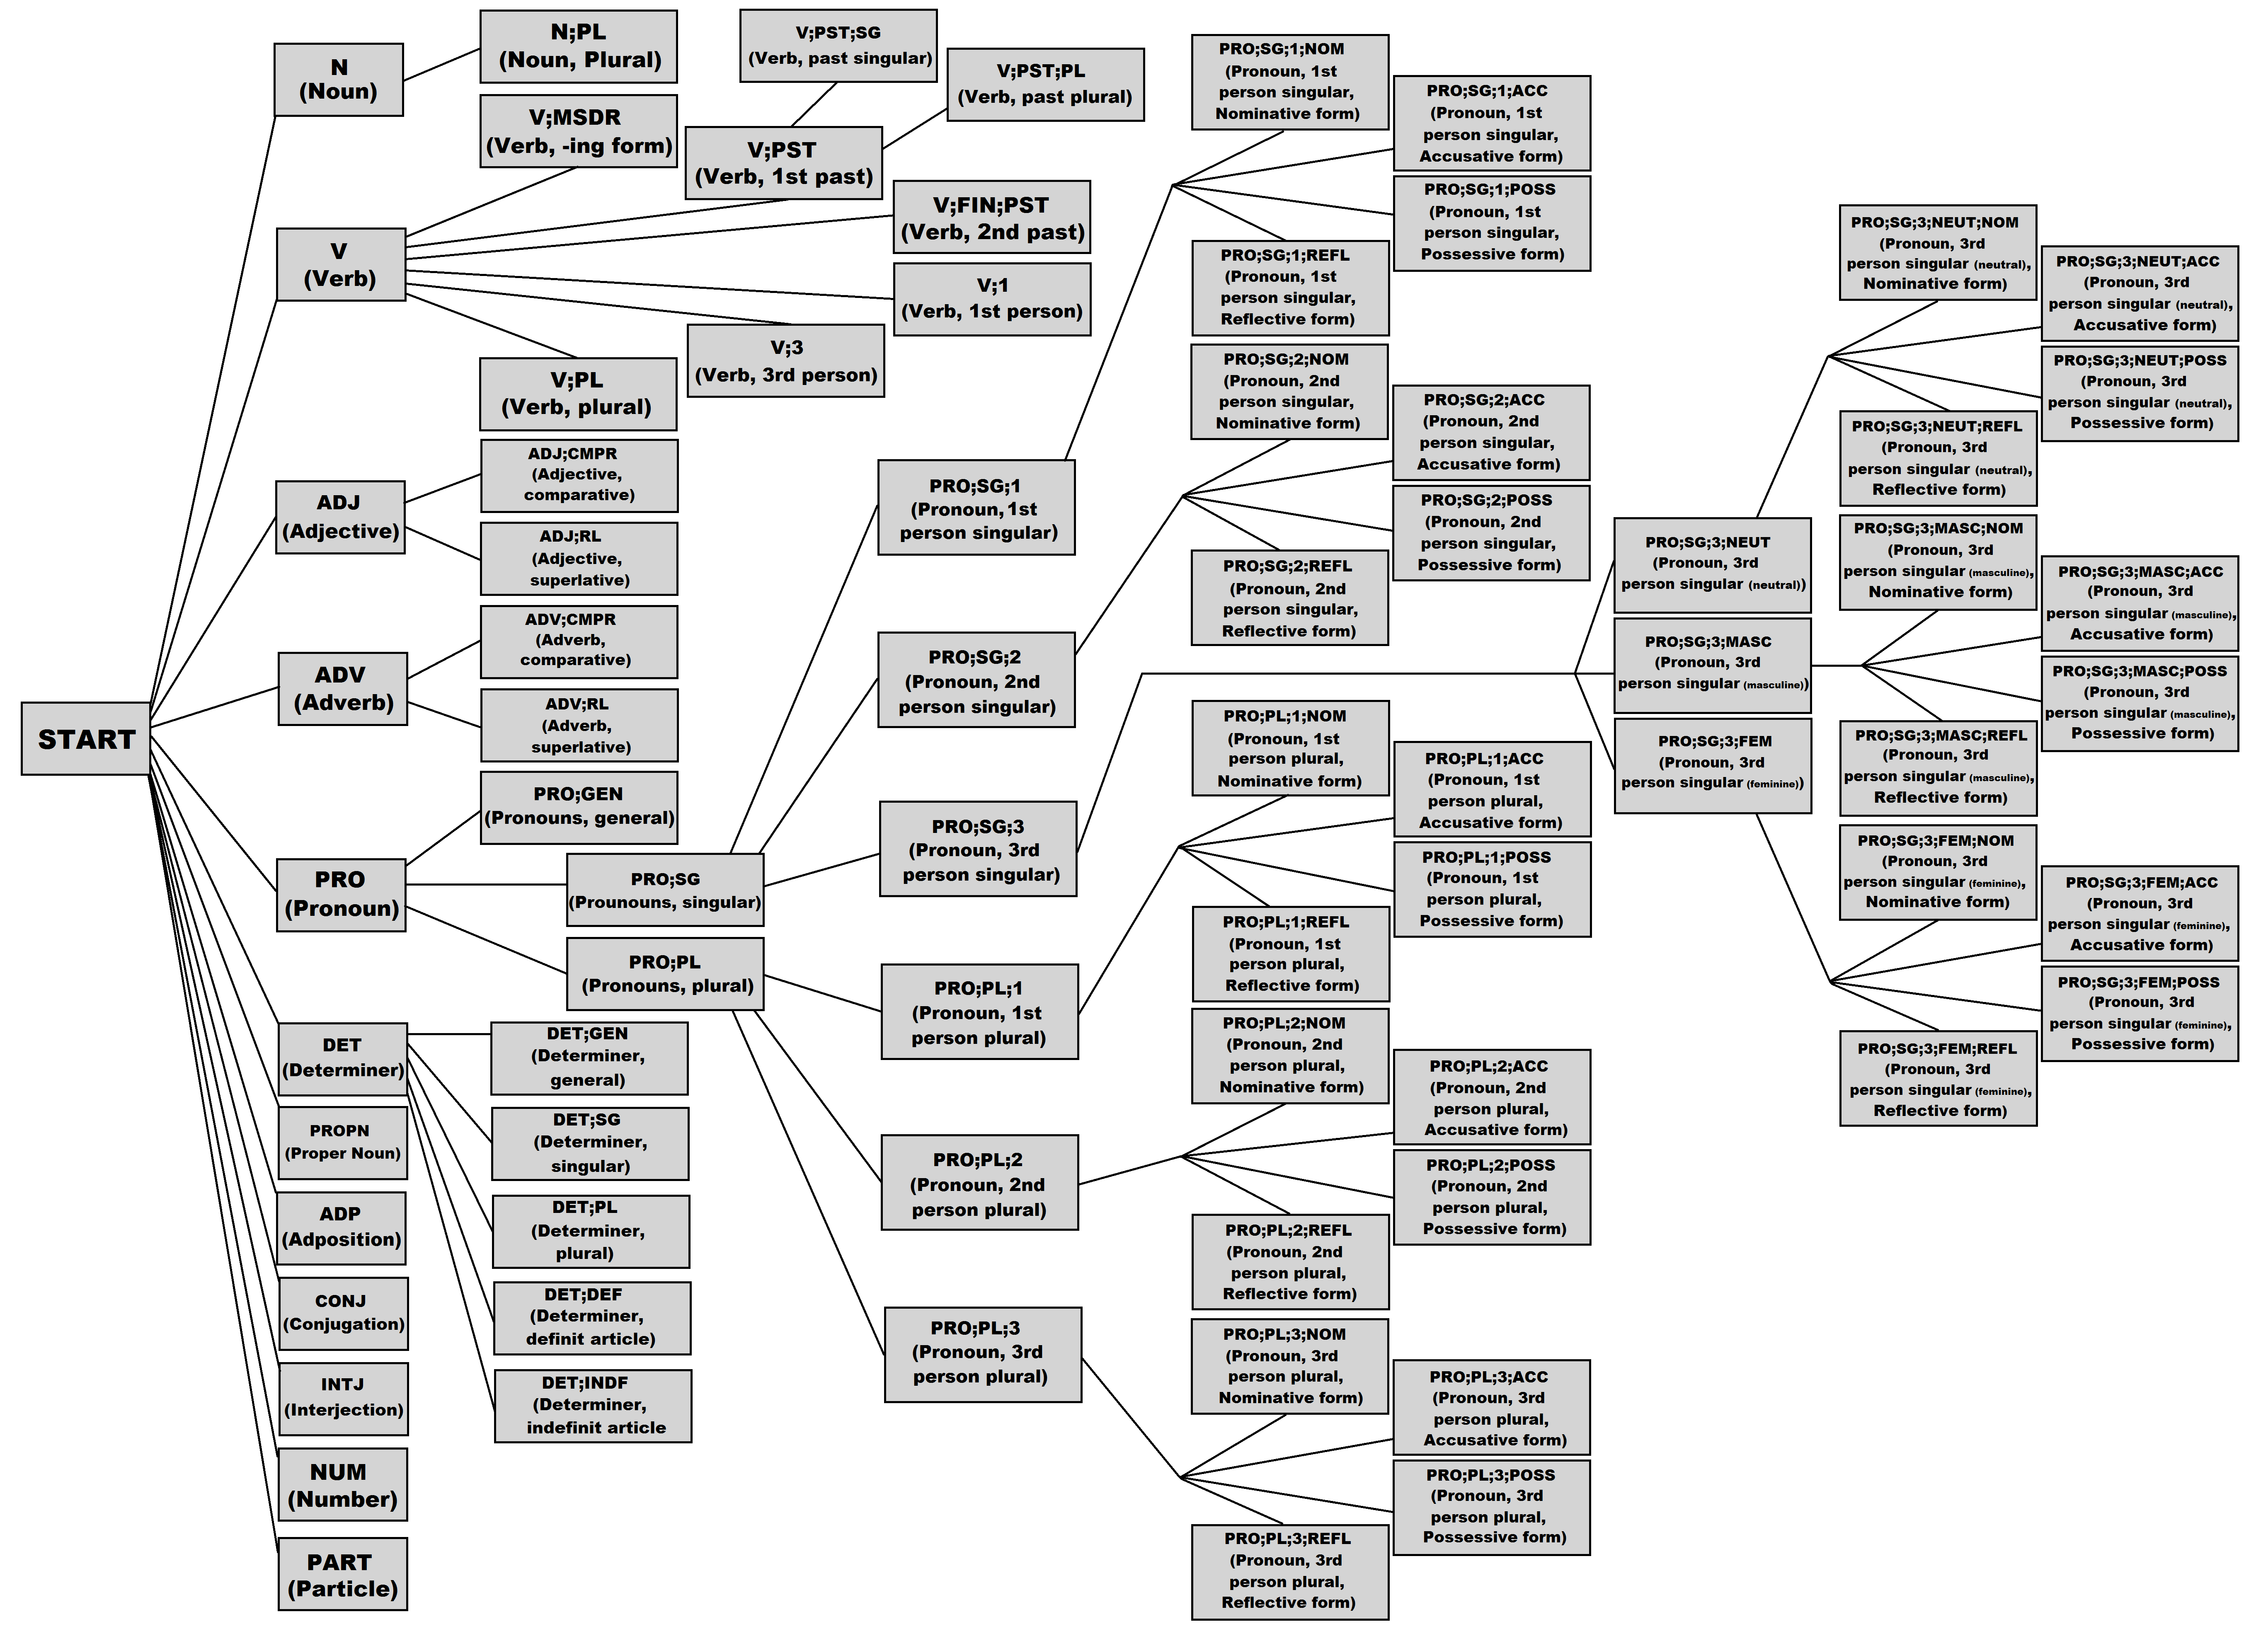

In [106]:
from IPython.display import Image
Image("Morpheme_Tree.png")

Here are the concrete Vertices of the Morpheme Tree I want to generate. (This is the part that heavily uses the lists generated in Part 3.)

In [107]:
Nouns = Vertex('N',Noun_list,['N;PL'])
Nouns_pl = Vertex('N;PL',Noun_PL_list,[])

Verbs = Vertex('V',Verb_list,['V;MSDR','V;PST','V;FIN;PST','V;1','V;3','V;PL'])
Verbs_ing = Vertex('V;MSDR',Verb_ing_list,[])
Verbs_pst = Vertex('V;PST',[],['V;PST;SG','V;PST;PL'])
Verbs_pst_sg = Vertex('V;PST;SG',Verb_past_list_SG,[])
Verbs_pst_pl = Vertex('V;PST;PL',Verb_past_list_PL,[])
Verbs_finpst = Vertex('V;FIN;PST',Verb_2nd_past_list,[])
Verbs_1 = Vertex('V;1',[v for v in Verb_list if v != 'be'] + ['am'],[])
Verbs_3 = Vertex('V;3',Verb_s_list,[])
Verbs_pl = Vertex('V;PL',[v for v in Verb_list if v != 'be'] + ['are'],[])

Adjs = Vertex('ADJ',Adj_list,['ADJ;CMPR','ADJ;RL'])
Adjs_cmpr = Vertex('ADJ;CMPR',Adj_cmpr_list,[])
Adjs_rl = Vertex('ADJ;RL',Adj_rl_list,[])

Advs = Vertex('ADV',Adv_list,['ADV;CMPR','ADV;RL'])
Advs_cmpr = Vertex('ADV;CMPR',Adv_cmpr_list,[])
Advs_rl = Vertex('ADV;RL',Adv_rl_list,[])

Pronouns = Vertex('PRO',[],['PRO;SG','PRO;PL','PRO;GEN'])
Pronouns_sg = Vertex('PRO;SG',[],['PRO;SG;1','PRO;SG;2','PRO;SG;3'])
Pronouns_pl = Vertex('PRO;PL',[],['PRO;PL;1','PRO;PL;2','PRO;PL;3'])
Pronouns_general = Vertex('PRO;GEN',Pro_gen,[])

Pronouns_sg_1 = Vertex('PRO;SG;1',[],
                       ['PRO;SG;1;NOM','PRO;SG;1;ACC','PRO;SG;1;POSS','PRO;SG;1;REFL'])
Pronouns_sg_2 = Vertex('PRO;SG;2',[],
                       ['PRO;SG;2;NOM','PRO;SG;2;ACC','PRO;SG;2;POSS','PRO;SG;2;REFL'])
Pronouns_sg_3 = Vertex('PRO;SG;3',[],
                       ['PRO;SG;3;NEUT','PRO;SG;3;MASC','PRO;SG;3;FEM'])
Pronouns_pl_1 = Vertex('PRO;PL;1',[],
                       ['PRO;PL;1;NOM','PRO;PL;1;ACC','PRO;PL;1;POSS','PRO;PL;1;REFL'])
Pronouns_pl_2 = Vertex('PRO;PL;2',[],
                       ['PRO;PL;2;NOM','PRO;PL;2;ACC','PRO;PL;2;POSS','PRO;PL;2;REFL'])
Pronouns_pl_3 = Vertex('PRO;PL;3',[],
                       ['PRO;PL;3;NOM','PRO;PL;3;ACC','PRO;PL;3;POSS','PRO;PL;3;REFL'])

Pronouns_sg_3_neut = Vertex('PRO;SG;3;NEUT',[],
            ['PRO;SG;3;NEUT;NOM','PRO;SG;3;NEUT;ACC','PRO;SG;3;NEUT;POSS','PRO;SG;3;NEUT;REFL'])
Pronouns_sg_3_masc = Vertex('PRO;SG;3;MASC',[],
            ['PRO;SG;3;MASC;NOM','PRO;SG;3;MASC;ACC','PRO;SG;3;MASC;POSS','PRO;SG;3;MASC;REFL'])
Pronouns_sg_3_fem = Vertex('PRO;SG;3;FEM',[],
            ['PRO;SG;3;FEM;NOM','PRO;SG;3;FEM;ACC','PRO;SG;3;FEM;POSS','PRO;SG;3;FEM;REFL'])

Pronouns_sg_1_nom = Vertex('PRO;SG;1;NOM',['i'],[])
Pronouns_sg_1_acc = Vertex('PRO;SG;1;ACC',['me'],[])
Pronouns_sg_1_poss = Vertex('PRO;SG;1;POSS',['my','mine'],[])
Pronouns_sg_1_refl = Vertex('PRO;SG;1;REFL',['myself'],[])
Pronouns_sg_2_nom = Vertex('PRO;SG;2;NOM',['you','u'],[])
Pronouns_sg_2_acc = Vertex('PRO;SG;2;ACC',['you','u'],[])
Pronouns_sg_2_poss = Vertex('PRO;SG;2;POSS',['your','ur','yours','urs'],[])
Pronouns_sg_2_refl = Vertex('PRO;SG;2;REFL',['yourself'],[])
Pronouns_sg_3_neut_nom = Vertex('PRO;SG;3;NEUT;NOM',['it'],[])
Pronouns_sg_3_neut_acc = Vertex('PRO;SG;3;NEUT;ACC',['it'],[])
Pronouns_sg_3_neut_poss = Vertex('PRO;SG;3;NEUT;POSS',['its'],[])
Pronouns_sg_3_neut_refl = Vertex('PRO;SG;3;NEUT;REFL',['itself'],[])
Pronouns_sg_3_masc_nom = Vertex('PRO;SG;3;MASC;NOM',['he'],[])
Pronouns_sg_3_masc_acc = Vertex('PRO;SG;3;MASC;ACC',['him','em',"'em"],[])
Pronouns_sg_3_masc_poss = Vertex('PRO;SG;3;MASC;POSS',['his'],[])
Pronouns_sg_3_masc_refl = Vertex('PRO;SG;3;MASC;REFL',['himself'],[])
Pronouns_sg_3_fem_nom = Vertex('PRO;SG;3;FEM;NOM',['she'],[])
Pronouns_sg_3_fem_acc = Vertex('PRO;SG;3;FEM;ACC',['her'],[])
Pronouns_sg_3_fem_poss = Vertex('PRO;SG;3;FEM;POSS',['her','hers'],[])
Pronouns_sg_3_fem_refl = Vertex('PRO;SG;3;FEM;REFL',['herself'],[])
Pronouns_pl_1_nom = Vertex('PRO;PL;1;NOM',['we'],[])
Pronouns_pl_1_acc = Vertex('PRO;PL;1;ACC',['us'],[])
Pronouns_pl_1_poss = Vertex('PRO;PL;1;POSS',['our','ours'],[])
Pronouns_pl_1_refl = Vertex('PRO;PL;1;REFL',['ourself','ourselves'],[])
Pronouns_pl_2_nom = Vertex('PRO;PL;2;NOM',['you','u'],[])
Pronouns_pl_2_acc = Vertex('PRO;PL;2;ACC',['you','u'],[])
Pronouns_pl_2_poss = Vertex('PRO;PL;2;POSS',['your','ur','yours','urs'],[])
Pronouns_pl_2_refl = Vertex('PRO;PL;2;REFL',['yourself','yourselves'],[])
Pronouns_pl_3_nom = Vertex('PRO;PL;3;NOM',['they'],[])
Pronouns_pl_3_acc = Vertex('PRO;PL;3;ACC',['them','em',"'em"],[])
Pronouns_pl_3_poss = Vertex('PRO;PL;3;POSS',['their','theirs'],[])
Pronouns_pl_3_refl = Vertex('PRO;PL;3;REFL',['themself','themselves'],[])

Dets = Vertex('DET',[],['DET;GEN','DET;SG','DET;PL','DET;DEF','DET;INDF'])
Dets_gen = Vertex('DET;GEN',Det_gen_list,[])
Dets_sg = Vertex('DET;SG',Det_sg_list,[])
Dets_pl = Vertex('DET;PL',Det_pl_list,[])
Dets_def = Vertex('DET;DEF',Det_def_list,[])
Dets_indf = Vertex('DET;INDF',Det_indf_list,[])

Prop_nouns = Vertex('PROPN',Propn_list,['PROPN;PL'])
Prop_nouns_pl = Vertex('PROPN;PL',Propn_pl_list,[])

Adps = Vertex('ADP',Adp_list,[])
Conjs = Vertex('CONJ',Conj_list,[])
Intjs = Vertex('INTJ',Intj_list,[])
Nums = Vertex('NUM',Num_list,[])
Parts = Vertex('PART',Part_list,[])

Then I'm building the Morpheme Tree using the defined Vertices and an extra "START" Vertex at the beginning.

In [108]:
MT = Morpheme_Tree({})
MT.add(Vertex('START',[],['N','V','ADJ','ADV','PRO','DET','PROPN','ADP','CONJ','INTJ','NUM','PART']))
all_POS = [Nouns, Nouns_pl, Verbs, Verbs_ing, Verbs_pst, Verbs_pst_sg, Verbs_pst_pl, Verbs_finpst,
          Verbs_1, Verbs_3, Verbs_pl, Adjs, Adjs_cmpr, Adjs_rl, Advs, Advs_cmpr, Advs_rl, Pronouns, 
          Pronouns_sg, Pronouns_pl, Pronouns_general, Pronouns_sg_1, Pronouns_sg_2, Pronouns_sg_3,
          Pronouns_pl_1, Pronouns_pl_2, Pronouns_pl_3, Pronouns_sg_3_neut, Pronouns_sg_3_masc,
          Pronouns_sg_3_fem, Pronouns_sg_1_nom, Pronouns_sg_1_acc, Pronouns_sg_1_poss,
          Pronouns_sg_1_refl, Pronouns_sg_2_nom, Pronouns_sg_2_acc, Pronouns_sg_2_poss,
          Pronouns_sg_2_refl, Pronouns_sg_3_neut_nom, Pronouns_sg_3_neut_acc, Pronouns_sg_3_neut_poss,
          Pronouns_sg_3_neut_refl, Pronouns_sg_3_masc_nom, Pronouns_sg_3_masc_acc,
          Pronouns_sg_3_masc_poss, Pronouns_sg_3_masc_refl, Pronouns_sg_3_fem_nom,
          Pronouns_sg_3_fem_acc, Pronouns_sg_3_fem_poss, Pronouns_sg_3_fem_refl, Pronouns_pl_1_nom,
          Pronouns_pl_1_acc, Pronouns_pl_1_poss, Pronouns_pl_1_refl, Pronouns_pl_2_nom,
          Pronouns_pl_2_acc, Pronouns_pl_2_poss, Pronouns_pl_2_refl, Pronouns_pl_3_nom,
          Pronouns_pl_3_acc, Pronouns_pl_3_poss, Pronouns_pl_3_refl, Dets, Dets_gen, Dets_sg ,Dets_pl,
          Dets_def, Dets_indf, Prop_nouns, Prop_nouns_pl, Adps, Conjs, Intjs, Nums, Parts]

for a in all_POS:
    MT.add(a)

Here are the names of Vertices in the Morpheme Tree:

In [109]:
MT.list_vertices()

['START', 'N', 'N;PL', 'V', 'V;MSDR', 'V;PST', 'V;PST;SG', 'V;PST;PL', 'V;FIN;PST', 'V;1', 'V;3', 'V;PL', 'ADJ', 'ADJ;CMPR', 'ADJ;RL', 'ADV', 'ADV;CMPR', 'ADV;RL', 'PRO', 'PRO;SG', 'PRO;PL', 'PRO;GEN', 'PRO;SG;1', 'PRO;SG;2', 'PRO;SG;3', 'PRO;PL;1', 'PRO;PL;2', 'PRO;PL;3', 'PRO;SG;3;NEUT', 'PRO;SG;3;MASC', 'PRO;SG;3;FEM', 'PRO;SG;1;NOM', 'PRO;SG;1;ACC', 'PRO;SG;1;POSS', 'PRO;SG;1;REFL', 'PRO;SG;2;NOM', 'PRO;SG;2;ACC', 'PRO;SG;2;POSS', 'PRO;SG;2;REFL', 'PRO;SG;3;NEUT;NOM', 'PRO;SG;3;NEUT;ACC', 'PRO;SG;3;NEUT;POSS', 'PRO;SG;3;NEUT;REFL', 'PRO;SG;3;MASC;NOM', 'PRO;SG;3;MASC;ACC', 'PRO;SG;3;MASC;POSS', 'PRO;SG;3;MASC;REFL', 'PRO;SG;3;FEM;NOM', 'PRO;SG;3;FEM;ACC', 'PRO;SG;3;FEM;POSS', 'PRO;SG;3;FEM;REFL', 'PRO;PL;1;NOM', 'PRO;PL;1;ACC', 'PRO;PL;1;POSS', 'PRO;PL;1;REFL', 'PRO;PL;2;NOM', 'PRO;PL;2;ACC', 'PRO;PL;2;POSS', 'PRO;PL;2;REFL', 'PRO;PL;3;NOM', 'PRO;PL;3;ACC', 'PRO;PL;3;POSS', 'PRO;PL;3;REFL', 'DET', 'DET;GEN', 'DET;SG', 'DET;PL', 'DET;DEF', 'DET;INDF', 'PROPN', 'PROPN;PL', 'ADP', 'CO

### Part 5: Morpheme-decomposition examples

The *lookup* method of the Tree can be used to lookup what the possible decompositions of each word are:<br>
(I'm also printing out the time, because it turned out to be quite fast.)

In [110]:
%%time
MT.lookup("hi")

Looked up "hi". 1 morpheme decomposition found:
INTJ
Wall time: 6.84 ms


In [111]:
%%time
MT.lookup("walk")

Looked up "walk". 5 morpheme decompositions found:
N
V
PROPN
V, 1
V, PL
Wall time: 6.34 ms


In [112]:
%%time
MT.lookup("walks")

Looked up "walks". 3 morpheme decompositions found:
N, PL
V, 3
PROPN, PL
Wall time: 6.82 ms


Note: Both "walk" and "walks" can be interpreted as a Noun or as a Verb.

In [113]:
%%time
MT.lookup("talk")

Looked up "talk". 4 morpheme decompositions found:
N
V
V, 1
V, PL
Wall time: 5.87 ms


In [114]:
%%time
MT.lookup("talks")

Looked up "talks". 3 morpheme decompositions found:
N
N, PL
V, 3
Wall time: 5.86 ms


Same for "talk" and "talks".

In [115]:
%%time
MT.lookup("his")

Looked up "his". 3 morpheme decompositions found:
PRO, GEN
DET, GEN
PRO, SG, 3, MASC, POSS
Wall time: 5.86 ms


In [116]:
%%time
MT.lookup("myself")

Looked up "myself". 1 morpheme decomposition found:
PRO, SG, 1, REFL
Wall time: 6.84 ms


### Part 6: Generating

I'm using the aforementioned *generate* and *generate_from* methods to get a random word with the given conjugation, or conjugate the given word.

In [117]:
MT.generate(['N'])

single


In [118]:
MT.generate(['V','FIN','PST'])

fetched


In [119]:
MT.generate(['ADJ','RL'])

most indefinable


In [120]:
MT.generate_from('house',['N','PL'])

'houses'

In [121]:
MT.generate_from('',['PL'])

No results found for word = , morpheme_list = ['PL'].


In [122]:
MT.generate_from('expensive',['CMPR'])

'more expensive'

In [123]:
MT.generate_from('she',['ACC'])

'her'

In [124]:
MT.generate_from('vertex', ['PL'])

No results found for word = vertex, morpheme_list = ['PL'].


The word "vertex" wasn't contained in our data base (in regular or conjugated forms). Our Morpheme Tree doesn't know that it's a noun, but we do!<br> In this case, we can use the regular noun plural transformer function:

In [125]:
noun_plural("vertex")

'vertices'

In [132]:
MT.lookup("painting")

Looked up "painting". 3 morpheme decompositions found:
N
PROPN
V, MSDR
